In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

In [3]:
from qat.core.console import display
from qat.lang.AQASM import Program, H
from qat.lang.AQASM.qftarith import QFT

In [4]:
sys.path.append('/home/gferro/ProgramasDefinitivos/')

In [5]:
from qat.lang.AQASM import Program, RY, CNOT, AbstractGate, QRoutine, Z, X
def load_U0(nqbits):
	"""
	Creates the gate U0, whose action is to flip the sign of the marked states.
	Marked states are those in which the auxiliary qubit has value 1, so this is achieved with a Z gate
	acting on that qubit. This function is more or less unnecessary.
	
	ARGUMENTS:
	nqbits (int) : number of qubits without including the auxiliary one
	
	RETURNS:
	U0_gate (ParamGate)
	"""
	U0 = AbstractGate("U0", [int])
	def U0_generator(nqbits):
		rout = QRoutine()
		reg = rout.new_wires(nqbits+1)
		rout.apply(Z, reg[-1])
		return rout
	U0.set_circuit_generator(U0_generator)
	U0_gate = U0(nqbits)
	return U0_gate

def load_U1(nqbits, P_gate, R_gate):
	"""
	Function that creates the gate which performs the operation of flipping the sign of the component along psi
	
	ARGUMENTS:
	nqbits (int) : number of qubits
	R_gate (ParamGate) : Gate that implements the operator R
	P_gate (ParamGate) : Gate that implements the operator P
	
	RETURNS:
	U1_gate (ParamGate)
	"""
	U1 = AbstractGate("U1", [int])
	def U1_generator(nqbits):
		rout = QRoutine()
		reg = rout.new_wires(nqbits+1)
		rout.apply(R_gate.dag(), reg)
		rout.apply(P_gate.dag(), reg[:-1])
		for wire in reg:
			rout.apply(X, wire)
		rout.apply(H, reg[-1])
		s = 'X' + '.ctrl()'*nqbits
		rout.apply(eval(s), reg)
		rout.apply(H, reg[-1])
		for wire in reg:
			rout.apply(X, wire)
		rout.apply(P_gate, reg[:-1])
		rout.apply(R_gate, reg)
		return rout
	U1.set_circuit_generator(U1_generator)
	U1_gate = U1(nqbits)
	return U1_gate

def load_Q(nqbits, P_gate, R_gate):
	"""
	Creates the Grover operator Q except a global phase, so it really creates the gate -Q
	
	ARGUMENTS:
	nqbits  (int)       : number of qubits
	U0_gate (ParamGate) : Gate U_psi_0
	U1_gate (ParamGate) : Gate U_psi
	
	RETURNS:
	Q_gate (ParamGate)  : Gate -Q=U1U0
	"""
	U0_gate = load_U0(nqbits)
	U1_gate = load_U1(nqbits, P_gate, R_gate)
	Q = AbstractGate("Q", [int])
	def Q_generator(nqbits):
		rout = QRoutine()
		reg  = rout.new_wires(nqbits+1)
		rout.apply(U0_gate, reg)
		rout.apply(U1_gate, reg)
		return rout
	Q.set_circuit_generator(Q_generator)
	Q_gate = Q(nqbits)
	return Q_gate, U0_gate, U1_gate


In [6]:
a = 0.
b = 1.
nqbits = 4
#_aux  = 8

In [7]:
def p(x):
    return x*x
def f(x):
    return np.sin(x)

In [8]:
from expectation_module import load_probabilities, load_function#, load_Q
centers, probs, P_gate = load_probabilities(nqbits, p, a, b)
R_gate, y = load_function(centers, f, nqbits)

In [44]:
from qat.lang.AQASM import Program, X, H, Z
qprog = Program()
qbits = qprog.qalloc(nqbits+1)
qprog.apply(P_gate, qbits[:-1])
qprog.apply(R_gate, qbits)
Q_gate, U0_gate, U1_gate  = load_Q(nqbits, P_gate, R_gate)
qprog.apply(Q_gate, qbits)
#qprog.apply(Z, qbits[-1])

In [45]:
circuit = qprog.to_circ()

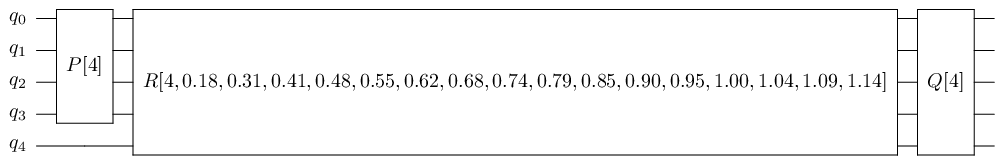

In [46]:
%qatdisplay circuit --depth 0

In [47]:
from qat.qpus import LinAlg

In [48]:
len(qbits)

5

In [49]:
linalgqpu = LinAlg()
result = linalgqpu.submit(circuit.to_job(qubits = [len(qbits)-1]))

In [50]:
States, QP, QA = [], [], []
for res in result:
    States.append(res.state) # Store the decimal number that represents each state
    QP.append(res.probability) # Store its probability
    QA.append(res.amplitude)
    print("Aux qbits have value %s (the probability of getting this result is %s)"%(res.state, res.probability))
QP = pd.Series(QP, name='Probability')  
States = pd.Series(States, name='States')  
QA = pd.Series(QA, name='Amplitude') 
pdf = pd.concat([States, QP, QA], axis=1)    

Aux qbits have value |0> (the probability of getting this result is 0.9302597084015397)
Aux qbits have value |1> (the probability of getting this result is 0.06974029159846046)


In [51]:
pdf

,States,Probability,Amplitude
0,|0>,0.93026,None
1,|1>,0.06974,None


In [41]:
np.sum(probs*y)

0.6693004071633366

In [54]:
Prob = 0.06974
K=0
Theta = np.arcsin(np.sqrt(Prob))/(2*K+1)
print('Theta: {}'.format(Theta))

Theta: 0.26725337863895515


In [55]:
np.pi

3.141592653589793

In [58]:
np.sin(3*Theta)

0.5163590524547841

In [ ]:
Theta: 0.9581124681207465

In [ ]:
len(states)

In [ ]:
[i for i in range(1, 2**(nqbits+1), 2)]

In [ ]:
[amplitudes[i] for i in range(1, len(probabilities), 2)]

In [ ]:
[states[i] for i in range(1, len(probabilities), 2)]

In [ ]:
result = PyLinalg().submit(circuit.to_job(qubits = [i+nqbits+1 for i in range(8)])) #Measure only auxiliary qubits


In [ ]:
[i+nqbits+1 for i in range(8)]

In [ ]:
qprog.apply(R_gate.dag(), qbits)
qprog.apply(P_gate.dag(), qbits[:-1])
for wire in qbits:
    qprog.apply(X, wire)
qprog.apply(H, qbits[-1])    
s = 'X' + '.ctrl()'*(nqbits)
qprog.apply(eval(s), qbits)
qprog.apply(H, qbits[-1])
for wire in qbits:
    qprog.apply(X, wire)
qprog.apply(P_gate, qbits[:-1])    
qprog.apply(R_gate, qbits)

In [ ]:
Q_gate, U0_gate, U1_gate  = load_Q(nqbits, P_gate, R_gate)

In [ ]:
qprog = Program()
qbits = qprog.qalloc(nqbits+1)
qprog.apply(P_gate, qbits[:-1])
qprog.apply(R_gate, qbits)
qprog.apply(U0_gate, qbits)
qprog.apply(U1_gate, qbits)

In [ ]:
circuit = qprog.to_circ()

In [ ]:
%qatdisplay circuit

In [ ]:
from qat.qpus import get_default_qpu
Algebra = get_default_qpu()

In [ ]:
result = Algebra.submit(circuit.to_job())

In [ ]:
states, probabilities, amplitudes = [], [], []
for res in result:
    states.append(res.state) # Store the decimal number that represents each state
    probabilities.append(res.probability) # Store its probability
    amplitudes.append(res.amplitude)
    print("Aux qbits have value %s (the probability of getting this result is %s)"%(
        res.state, res.amplitude))

In [ ]:
[amplitudes[i] for i in range(1, len(probabilities), 2)]

In [ ]:
[states[i] for i in range(1, len(probabilities), 2)]

In [ ]:
Aux qbits have value |000> (the probability of getting this result is 0.028383331462190166)
Aux qbits have value |001> (the probability of getting this result is 0.00018141230651445058)
Aux qbits have value |010> (the probability of getting this result is 0.18494344667884596)
Aux qbits have value |011> (the probability of getting this result is 0.004796618228824582)
Aux qbits have value |100> (the probability of getting this result is 0.33634130293762543)
Aux qbits have value |101> (the probability of getting this result is 0.021284153359982263)
Aux qbits have value |110> (the probability of getting this result is 0.36934453263582345)
Aux qbits have value |111> (the probability of getting this result is 0.05472520239019354)


* Aux qbits have value |010> (the probability of getting this result is 0.0678993718836378)
* Aux qbits have value |011> (the probability of getting this result is 0.03924348525921941)
* Aux qbits have value |100> (the probability of getting this result is 0.12348295448200526)
* Aux qbits have value |101> (the probability of getting this result is 0.1741360931370422)
* Aux qbits have value |110> (the probability of getting this result is 0.13559962369565087)
* Aux qbits have value |111> (the probability of getting this result is 0.44773370963768266)
